# SMM with Gradient Descent

## Python Imports

In [1]:
import numpy as np
import random
import copy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from itertools import combinations

## Data Imports

## DEFINE THE PATH TO YOUR COURSE DIRECTORY

In [2]:
data_dir = "data/"

### Hannah's partition scheme and loading

In [3]:
def load_blosum(filename):
    """
    Read in BLOSUM values into matrix.
    """
    aa = ['A', 'R', 'N' ,'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    df = pd.read_csv(filename, sep=' ', comment='#', index_col=0)
    return df.loc[aa, aa]

def load_peptide_target(filename, MAX_PEP_SEQ_LEN=9):
    """
    Read amino acid sequence of peptides and
    corresponding log transformed IC50 binding values from text file.
    """
    df = pd.read_csv(filename, sep=' ', usecols=[0,1], names=['peptide','target'])
    return df[df.peptide.apply(len) <= MAX_PEP_SEQ_LEN]

def load_pickle(f):
    with open(f, 'rb') as source:
        s = pickle.load(source)
    return s

def load_partitions(files):
    o = []
    for f in files:
        data = load_pickle(f)
        o += data
    return o

def assign_cv_partition(partition_files, n_folds=5, n_test=1):
    """Figure out all combinations of partition_files to assign as train and test data in CV"""

    # how many combinations of partition_files in train part
    n_train = n_folds - n_test

    # find all combinations of the partition_files with n_train files in each
    train_files = list(combinations(partition_files, n_train))

    # convert each list element to tuple so (train_partitions, test_partition)
    files = [
        (x, list(set(partition_files) - set(x))) for x in train_files
    ]

    return files

def data_partition(partition_files, data, blosum_file, batch_size=32, n_features=9):
    partitions = load_partitions(partition_files)

    selected_data = data.loc[data.peptide.isin(partitions), ].reset_index()

    X, y = encode_peptides(selected_data, blosum_file=blosum_file, batch_size=batch_size, n_features=n_features)

    # reshape X
    X = X.reshape(X.shape[0], -1)

    return X, y

def encode_peptides(Xin, blosum_file, batch_size, n_features, MAX_PEP_SEQ_LEN=9):
    """
    Encode AA seq of peptides using BLOSUM50.
    Returns a tensor of encoded peptides of shape (batch_size, MAX_PEP_SEQ_LEN, n_features)
    """
    blosum = load_blosum(blosum_file)
    
    batch_size = len(Xin)
    n_features = len(blosum)
    
    Xout = np.zeros((batch_size, MAX_PEP_SEQ_LEN, n_features), dtype=np.int8) # should it be uint? is there a purpose to that?
    
    for peptide_index, row in Xin.iterrows():
        for aa_index in range(len(row.peptide)):
            Xout[peptide_index, aa_index] = blosum[ row.peptide[aa_index] ].values
            
    return Xout, Xin.target.values

data = load_peptide_target('data/A0201/A0201.dat')


### Alphabet

In [4]:
alphabet_file = data_dir + "Matrices/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)

## Error Function

In [5]:
def cumulative_error(peptides, y, lamb, weights):

    error = 0
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]

        # get target prediction value
        y_target = y[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
            
        # calculate error
        error += 1.0/2 * (y_pred - y_target)**2
        
    gerror = error + lamb*np.dot(weights, weights)
    error /= len(peptides)
        
    return gerror, error

## Predict value for a peptide list

In [6]:
def predict(peptides, weights):

    pred = []
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
        
        pred.append(y_pred)
        
    return pred


## Calculate MSE between two vectors

In [7]:
def cal_mse(vec1, vec2):
    
    mse = 0
    
    for i in range(0, len(vec1)):
        mse += (vec1[i] - vec2[i])**2
        
    mse /= len(vec1)
    
    return( mse)

## Gradient Descent

In [8]:
def gradient_descent(y_pred, y_target, peptide, weights, lamb_N, epsilon):
    
    # do is dE/dO
    #do = XX
    do = y_pred - y_target
    
    for i in range(0, len(weights)):
        
        #de_dw_i = XX
        de_dw_i = do * peptide[i] + 2 * lamb_N * weights[i]
        #weights[i] -= XX
        weights[i] -= epsilon * de_dw_i

### Make storage for inner loop predictions

In [9]:
def make_storage(hyper_parameter_1, hyper_parameter_2):
    store_predictions={}

    for i in hyper_parameter_1:
    
        store_predictions[i]={}
    
        for j in hyper_parameter_2:
        
            store_predictions[i][j] = []
    return(store_predictions)



## Main Loop



In [10]:
partition_files = ['data/partition_3.txt', 'data/partition_2.txt', 'data/partition_6.txt', 'data/partition_5.txt', 'data/partition_4.txt']

storage_pred = make_storage(["a"],["b"])
storage_target = make_storage(["a"],["b"])
K1 = 5
best_lambda_list = [10,0.1,0.001,0.01,1]

epochs = 100

#Use Hannahs encoding loading
encoding_file = 'data/BLOSUM50' # could change it to data/sparse

# Random seed 
np.random.seed( 1 )

# early stopping
early_stopping = True

outer_partitions = assign_cv_partition(partition_files, n_folds=K1)

for k, (outer_train, outer_test) in enumerate(outer_partitions):
    #get outer training set from outer partition for training with optimal parameters
    outer_peptides, outer_y = data_partition(outer_train, data=data, blosum_file=encoding_file)
    
    #get validation set from the outer partition to validate model one
    validation_peptides, validation_targets = data_partition(outer_test, data=data, blosum_file=encoding_file)
    print(k)
    N = len(outer_peptides)
    lamb=best_lambda_list[k]
    lamb_N = lamb/N
    epsilon=5e-05
    stopping_error = np.inf # for early stopping
    # weights
    input_dim  = len(outer_peptides[0])
    w_bound = 0.1
    weights = np.random.uniform(-w_bound, w_bound, size=input_dim)
    best_weights = np.zeros(input_dim)
                
    # for each training epoch
    for e in range(0, epochs):

        # for each peptide
        for i in range(0, N):

            # random index
            ix = np.random.randint(0, N)

            # get peptide       
            peptide = outer_peptides[ix]

            # get target prediction value
            y_target = outer_y[ix]
            #print(y_target)
            # get initial prediction
            y_pred = np.dot(peptide, weights)
            #print(y_pred)
            # gradient descent 
            gradient_descent(y_pred, y_target, peptide, weights, lamb_N, epsilon) # updates weights

        #compute error, needed for plot
        #gerr, mse = cumulative_error(outer_peptides, outer_y, lamb, weights) 

        # predict on training data, only needed for plots
        #train_pred = predict( outer_peptides, weights )
        #train_mse = cal_mse( outer_y, train_pred )
        #train_pcc = pearsonr( outer_y, train_pred )

        # predict on outer test (validation data)
        eval_pred = predict(validation_peptides, weights )
        eval_mse = cal_mse(validation_targets, eval_pred )
        #eval_pcc = pearsonr(validation_targets, eval_pred) don't calculate it unless needed

        # early stopping
        if early_stopping:

            if eval_mse < stopping_error:

                stopping_error = eval_mse # save to compare future loops
                stopping_pcc = pearsonr(validation_targets, eval_pred)[0]
                stopping_pred = eval_pred[:]
    storage_pred["a"]["b"].extend(stopping_pred)
    storage_target["a"]["b"].extend(validation_targets)
    print("Lambda: ", lamb,"Epsilon: ", epsilon, "PCC: ", stopping_pcc)


0
Lambda:  10 Epsilon:  5e-05 PCC:  0.6534968265472312
1
Lambda:  0.1 Epsilon:  5e-05 PCC:  0.7030511675299668
2
Lambda:  0.001 Epsilon:  5e-05 PCC:  0.7420535908473012
3
Lambda:  0.01 Epsilon:  5e-05 PCC:  0.721616142439651
4
Lambda:  1 Epsilon:  5e-05 PCC:  0.6803707819979028


### Input Marius' code

<class 'list'>


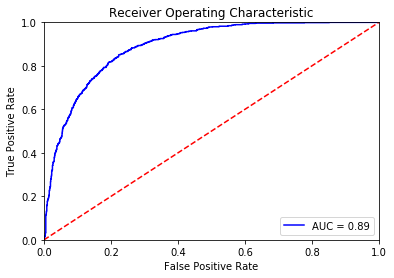

Preds and targets normally distributed (according to shapiro)
PCC (0.6999869897813613, 0.0)


No handles with labels found to put in legend.


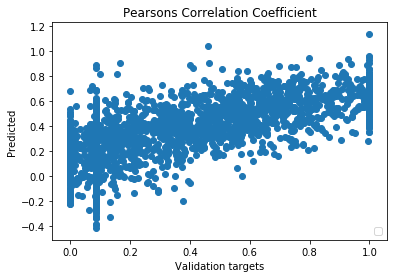

No handles with labels found to put in legend.


SCC SpearmanrResult(correlation=0.7201120523358466, pvalue=0.0)


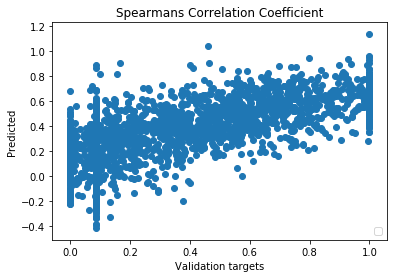

In [39]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

import seaborn as sns

from scipy import stats

# BINDER_THRESHOLD (from Helle - I guess we use this, but not sure what the best argumentation would be)
BINDER_THRESHOLD = 0.426

#fill out
x_test =np.asarray(storage_pred["a"]["b"])
y_test =np.asarray(storage_target["a"]["b"])
pred =np.asarray(storage_pred["a"]["b"])
print(type(storage_pred["a"]["b"]))
targets = np.asarray(storage_target["a"]["b"])

### ROC/AUC
## net.eval depending on method - here ANN
#net.eval()
#pred = net(x_test)
#loss = criterion(pred, y_test)

#plot_target_values(data=[(pd.DataFrame(pred.data.numpy(), columns=['target']), 'Prediction'),
#                         (test_raw, 'Target')])

y_test_class = np.where(y_test.flatten() >= BINDER_THRESHOLD, 1, 0)
y_pred_class = np.where(pred.flatten() >= BINDER_THRESHOLD, 1, 0)
#y_test_class = np.where(y_test >= BINDER_THRESHOLD, 1, 0)
#y_pred_class = np.where(pred >= BINDER_THRESHOLD, 1, 0)

#fpr, tpr, threshold = roc_curve(y_test_class, pred.flatten().detach().numpy())
fpr, tpr, threshold = roc_curve(y_test_class, pred.flatten())

roc_auc = auc(fpr, tpr)



def plot_roc_curve():
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_roc_curve()


### SCC and PCC

scc = stats.spearmanr(pred, targets)
def plot_scc():
    plt.title('Spearmans Correlation Coefficient')
    #plt.scatter(y_test.flatten().detach().numpy(), pred.flatten().detach().numpy(), label = 'SCC = %0.2f' % scc)
    plt.scatter(y_test, pred)#, label = 'SCC = %0.2f' % scc)
    plt.legend(loc = 'lower right')
    plt.ylabel('Predicted')
    plt.xlabel('Validation targets')
    plt.show()


pcc = stats.pearsonr(pred, targets)
def plot_pcc():
    plt.title('Pearsons Correlation Coefficient')
    #plt.scatter(y_test.flatten().detach().numpy(), pred.flatten().detach().numpy(), label = 'PCC = %0.2f' % pcc)
    plt.scatter(y_test, pred)#, label = 'PCC = %0.2f' % pcc)
    plt.legend(loc = 'lower right')
    plt.ylabel('Predicted')
    plt.xlabel('Validation targets')
    plt.show()


### Spearman
if stats.shapiro(pred)[1] < 0.05 and stats.shapiro(targets)[1] < 0.05:
    print('Preds and targets normally distributed (according to shapiro)')
    print('PCC', stats.pearsonr(pred, targets))
    plot_pcc()
    print('SCC', stats.spearmanr(pred, targets))
    plot_scc()
else:
    print('Preds and targets not normally distributed (according to shapiro) -> only do Spearman')
    print('SCC', stats.spearman(pred, targets))
    plot_scc()